In [2]:
import numpy as np
from music21 import midi, note, stream, instrument, meter, key, duration
from music21.note import Rest

print(1)
mf = midi.MidiFile()
mf.open("Bolero-RavelShorten.mid")
mf.read()
mf.close()
print(len(mf.tracks))
s = stream.Stream()
s.append(midi.translate.midiFileToStream(mf))
s


1
1


<music21.stream.Stream 0x7f465ac54610>

In [3]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

In [50]:
new_stream = stream.Stream()
ts = meter.TimeSignature('3/4')

new_stream.insert(0, ts)
new_stream.insert(0, instrument.Guitar())

i = 0
ratio = 1/10

for n in s.flat.notes[0:100]:
    i+=1

    if((i-1)%int(20/i +1)== 0 ): # TODO faire 
        new_stream.append(n)
    else:
        r = note.Rest()
        r.duration = n.duration
        new_stream.append(r)




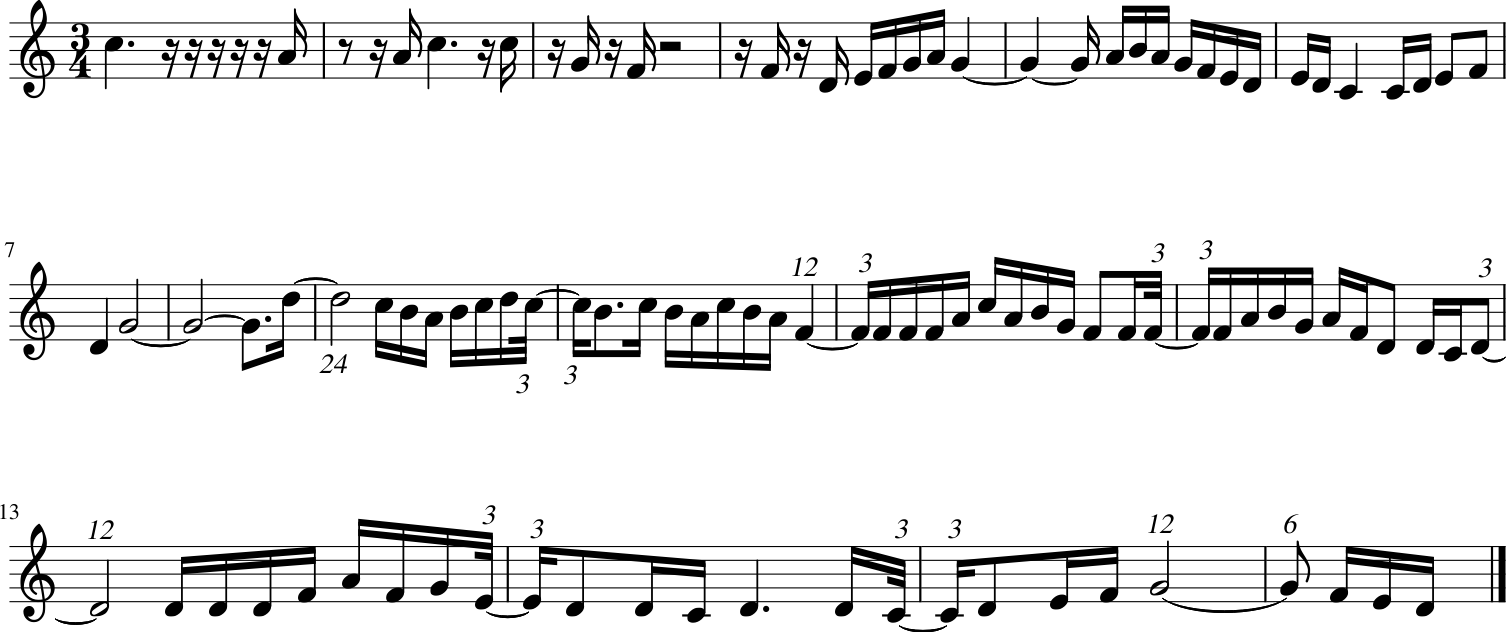

In [51]:
new_stream.show()

In [52]:

play(new_stream)